In [1]:
import numpy as np
import os
from sklearn.linear_model import LogisticRegression
import h5py
import pandas
import time
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [2]:
def true_positive(thres, probs, classes):
    pos = (probs > thres)
    true_pos = pos & classes
    return np.sum(true_pos) / np.sum(classes) # true positive / all true positive

def false_positive(thres, probs, classes):
    pos = (probs > thres)
    false_pos = pos & (~classes)
    return np.sum(false_pos) / np.sum(~classes) # false positive / all true negative


In [3]:
names = [
    #"Nearest Neighbors",
    #"Linear SVM",
    #"RBF SVM",
    #"Gaussian Process",
    #"Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    #"Naive Bayes",
    "QDA",
]

classifiers = [
    #KNeighborsClassifier(3),
    #SVC(kernel="linear", C=0.025),
    #SVC(gamma=2, C=1),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    #DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=4, n_estimators=100),
    MLPClassifier(hidden_layer_sizes=(15), alpha=0.001, max_iter=500),
    AdaBoostClassifier(),
    #GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]


In [17]:
folder = '/home/saturn/caph/mpp228/CTA_data/Prod5_GRID/Prod5_square_images/'
ev_types = ['proton', 'gamma-diffuse']
n_events = 5*10**4
ntot = n_events * len(ev_types)
#n_events = 1000
image_keys = ['image', 'image_mask']
data0 = pandas.DataFrame(columns=['CR_type'], data=np.zeros(ntot))

# get keys and dimensions
fn = folder + '%s_%i_images.h5' % (ev_types[0], n_events)
with h5py.File(fn, 'r') as f:
    for key in f.keys():
        if key not in image_keys:
            data0[key] = np.zeros(ntot, dtype=np.float32)

# load meta data
for k, event_type in enumerate(ev_types):
    fill_inds = list(range(n_events * k, n_events * (k + 1)))
    fn = folder + '%s_%i_images.h5' % (event_type, n_events)
    with h5py.File(fn, 'r') as f:
        for key in data0.columns:
            if key == 'CR_type':
                data0[key][fill_inds] = int(event_type != 'proton')
            else:
                data0[key][fill_inds] = f[key][:]

target_vars = ['CR_type', 'true_alt', 'true_az', 'true_energy']
feature_vars = [key for key in data0.columns if key not in target_vars]
feature_vars.remove('morphology_num_pixels')
#feature_vars = ['hillas_intensity', 'hillas_width', 'morphology_num_medium_islands',]

/home/woody/caph/mpp228/apps/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/woody/caph/mpp228/apps/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [45]:
good_mask = ~np.isnan(np.sum(data0.values, axis=1))
data = data0[good_mask]
smin = 200
smax = 10000
size_mask = (smin < data['hillas_intensity']) & (smax > data['hillas_intensity'])
data = data[size_mask]
ntot = len(data)
print(ntot)

46047


In [46]:
np.random.seed(5)
inds = np.arange(ntot)
shuffle = True
if shuffle:
    np.random.shuffle(inds)


pick_fraction = 1.
inds = inds[:int(pick_fraction * len(inds))]

train_fraction = 0.6
split_ind = int(len(inds) * train_fraction)
train_inds = inds[:split_ind]
test_inds = inds[split_ind:ntot]
print(len(train_inds), len(test_inds))
#print(train_inds[:10], test_inds[:10])

27628 18419


In [47]:
x_train = data[feature_vars].iloc[train_inds]
x_test = data[feature_vars].iloc[test_inds]
#x_train

In [48]:
target_key = 'CR_type'
y_train = data[target_key].iloc[train_inds]
y_test = data[target_key].iloc[test_inds]
#y_train, y_test

In [49]:
res_dict = {}
for name, clf in zip(names, classifiers):
    t0 = time.time()
    print(name)
    clf.fit(x_train, y_train)
    score = clf.score(x_test, y_test)
    res_dict[name] = clf
    print('Score: %.3f (%.3f s)' % (score, (time.time() - t0)))

Random Forest
Score: 0.740 (2.690 s)
Neural Net
Score: 0.594 (2.921 s)
AdaBoost
Score: 0.752 (2.357 s)
QDA
Score: 0.686 (0.028 s)


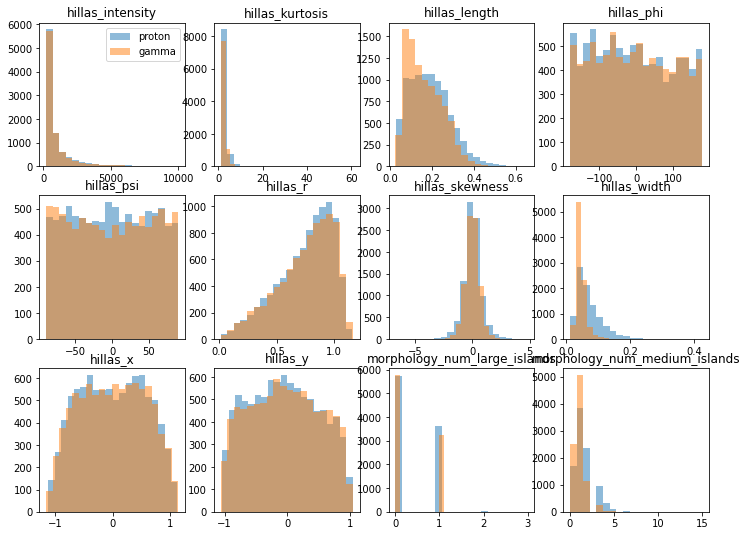

In [50]:
#bins = np.linspace(-5, 5, 100)
if 0:
    y_mask = (data['CR_type'] == 1)
    xs1 = np.array(data[feature_vars]).T[:, ~y_mask] # protons
    xs2 = np.array(data[feature_vars]).T[:, y_mask] # not protons
else:
    y_mask = np.array(y_test, dtype=bool)
    xs1 = np.array(x_test).T[:, ~y_mask] # protons
    xs2 = np.array(x_test).T[:, y_mask] # not protons

bins = 20
ncol = 4
nraw = int(np.ceil(len(feature_vars) / ncol))
plt.figure(figsize=(ncol * 3, nraw * 3))
for i, name in enumerate(feature_vars):
    plt.subplot(nraw, ncol, i + 1)
    #plt.figure()
    plt.hist(xs1[i], alpha=0.5, bins=bins, label='proton')
    plt.hist(xs2[i], alpha=0.5, bins=bins, label='gamma')
    plt.title(name)
    if i == 0:
        plt.legend()

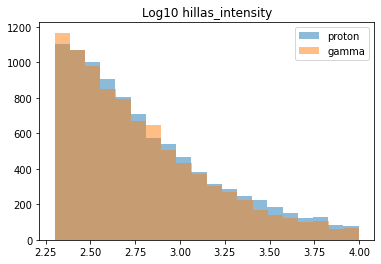

In [51]:
key = 'hillas_intensity'
if key in feature_vars:
    plt.figure()
    x1 = np.log10(x_test[key][~y_mask])
    x2 = np.log10(x_test[key][y_mask])
    plt.hist(x1, alpha=0.5, bins=bins, label='proton')
    plt.hist(x2, alpha=0.5, bins=bins, label='gamma')
    plt.legend()
    plt.title('Log10 %s' % key)


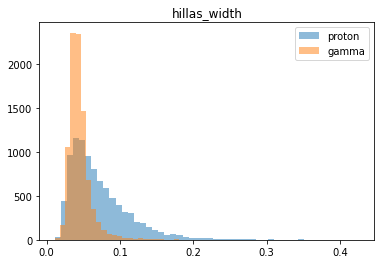

In [52]:
key = 'hillas_width'
if key in feature_vars:
    plt.figure()
    x1 = x_test[key][~y_mask]
    x2 = x_test[key][y_mask]
    plt.hist(x1, alpha=0.5, bins=50, label='proton')
    plt.hist(x2, alpha=0.5, bins=50, label='gamma')
    plt.legend()
    plt.title(key);


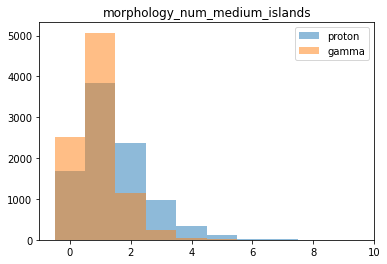

In [53]:
key = 'morphology_num_medium_islands'
if key in feature_vars:
    plt.figure()
    x1 = x_test[key][~y_mask]
    x2 = x_test[key][y_mask]
    plt.hist(x1, alpha=0.5, bins=np.arange(-0.5, 10, 1), label='proton')
    plt.hist(x2, alpha=0.5, bins=np.arange(-0.5, 10, 1), label='gamma')
    plt.legend()
    plt.title(key);


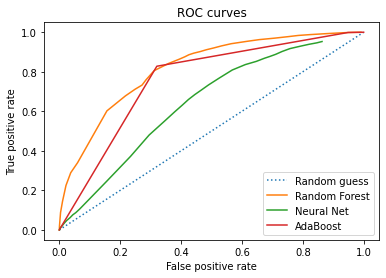

In [54]:
classes = y_test.astype(bool)
thresholds = np.arange(0.1, 0.91, 0.02)
plt.figure()
plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), ls=':', label='Random guess')
for name in ['Random Forest', "Neural Net", "AdaBoost"]:
    clf = res_dict[name]
    probs = clf.predict_proba(x_test)[:,1]
    
    tpr = [true_positive(thres, probs, classes) for thres in thresholds]
    fpr = [false_positive(thres, probs, classes) for thres in thresholds]

    
    plt.plot(fpr, tpr, label=name)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curves')
plt.legend()

In [55]:
for name in ['Random Forest', "Neural Net", "AdaBoost"]:
    clf = res_dict[name]

    print('Training score (%s): %.3f' % (name, clf.score(x_train, y_train)))
    print('Testing score (%s): %.3f' % (name, clf.score(x_test, y_test)))
    print()


Training score (Random Forest): 0.741
Testing score (Random Forest): 0.740

Training score (Neural Net): 0.591
Testing score (Neural Net): 0.594

Training score (AdaBoost): 0.758
Testing score (AdaBoost): 0.752



In [56]:
if 1:
    clf = res_dict['Random Forest']
    rf_imp = clf.feature_importances_
    for i, name in enumerate(feature_vars):
        print('%s: %.3f' % (name, rf_imp[i]))

hillas_intensity: 0.051
hillas_kurtosis: 0.091
hillas_length: 0.044
hillas_phi: 0.001
hillas_psi: 0.001
hillas_r: 0.008
hillas_skewness: 0.016
hillas_width: 0.567
hillas_x: 0.001
hillas_y: 0.002
morphology_num_large_islands: 0.028
morphology_num_medium_islands: 0.191


In [57]:
#for name in ['Random Forest', "Neural Net", "AdaBoost"]:
name = 'Random Forest'
clf = res_dict[name]
probs = clf.predict_proba(x_test)[:,1]

In [58]:
x_test.keys()

Index(['hillas_intensity', 'hillas_kurtosis', 'hillas_length', 'hillas_phi',
       'hillas_psi', 'hillas_r', 'hillas_skewness', 'hillas_width', 'hillas_x',
       'hillas_y', 'morphology_num_large_islands',
       'morphology_num_medium_islands'],
      dtype='object')

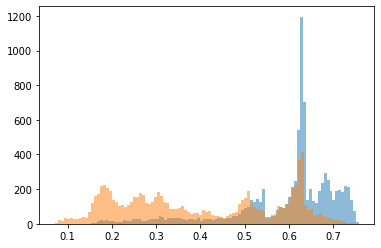

In [59]:
plt.hist(probs[y_mask], alpha=0.5, bins=100); # gamma
plt.hist(probs[~y_mask], alpha=0.5, bins=100); # proton